First we do basic data prep. We load the time-series data into a pandas dataframe, and make sure the data column is in a readable datetime format.

In [134]:
import pandas as pd
import numpy as np

# Load your data into a DataFrame
data = pd.read_csv('data_daily.csv')

# Convert the date column to a datetime format
data['Date'] = pd.to_datetime(data['# Date'])
data.drop(columns = ['# Date'], inplace = True)
data.set_index('Date', inplace=True)
data.head()

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


Next, we do preproccessing. We make sure hte data is sorted by date, and handle any missing values if neccessary.

In [135]:
# Sort the data by date
data.sort_values('Date', inplace=True)

# Handle missing values if necessary
data['Receipt_Count'].fillna(0, inplace=True)
data['DayOfYear'] = data.index.dayofyear

#split into train and test. First 80% is used for training
train_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

After examining the data, we can see that while there is some noise, mostly it's a simple line. Therefore we're going to do linear regression


In [136]:
#usually i'd use sklearn.Llinear_model.LinearRegression
X_train = np.column_stack((train_data['DayOfYear'], np.ones(len(train_data))))
y_train = train_data['Receipt_Count'].values

# Calculate the coefficients using the normal equation
coefficients = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train


Percent Error for Total Sum: -0.28%
MSE for Test Data: 49258437847.3441


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

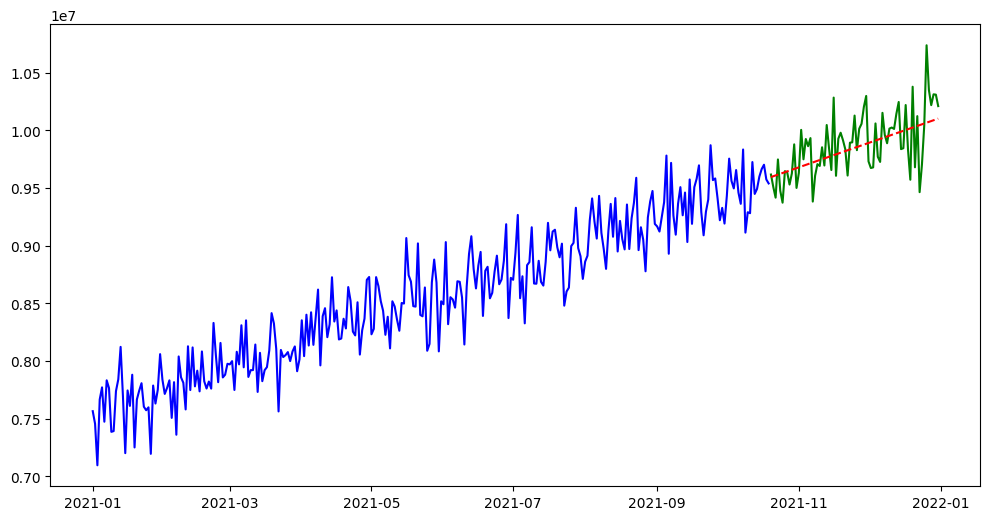

In [137]:
# Define the features and target variable for test data
X_test = np.column_stack((test_data['DayOfYear'], np.ones(len(test_data))))
y_test = test_data['Receipt_Count'].values

# Make daily forecasts for the test data
test_forecasts = X_test @ coefficients

# Calculate the percent error for the total sum
total_actual = y_test.sum()
total_forecast = test_forecasts.sum()
percent_error = ((total_forecast - total_actual) / total_actual) * 100

print(f'Percent Error for Total Sum: {percent_error:.2f}%')

# Calculate Mean Squared Error (MSE) for the test data
mse_test = np.mean((test_forecasts - y_test) ** 2)
print(f'MSE for Test Data: {mse_test:.4f}')

# Plot the actual and forecasted values for both training and test data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Receipt_Count'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Receipt_Count'], label='Test Data', color='green')
plt.plot(test_data.index, test_forecasts, label='Test Forecast', linestyle='--', color='red')
plt.xlabel


We can see that the percent error for the SUM of all our daily estimates compared to the SUM of the actual values is only -0.28%, which is excellent. This is a good indication that this strategy of linear regression works. Next we're going to continue this strategy to forecast out to the end of 2022

In [165]:
# Create a date range for 2022
forecast_dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Create a DataFrame for 2022 with the 'DayOfYear' feature
forecast_data = pd.DataFrame({'Date': forecast_dates})
forecast_data.set_index('Date', inplace=True)
forecast_data['DayOfYear'] = forecast_data.index.dayofyear + 365
forecast_data['Month'] = forecast_data.index.month

# Create the feature matrix for 2022 (only 'DayOfYear')
X_forecast = np.column_stack((forecast_data['DayOfYear'], np.ones(len(forecast_data))))

# Make daily forecasts for 2022
daily_forecasts = X_forecast @ coefficients

# Add the forecasts to the DataFrame
forecast_data['Forecast'] = daily_forecasts

Now we have daily forecasts for every day! We only have to groupby month and sum to get our monthly predictions.

In [166]:
# Calculate the rounded monthly forecasts for 2022
monthly_forecast_data = forecast_data.groupby(forecast_data.index.month)['Forecast'].sum()

print(monthly_forecast_data)


Date
1    316673295.47
2    291843775.71
3    329552207.89
4    325364468.47
5    342867693.62
6    338250422.40
7    356183179.34
8    362950065.53
9    357684975.86
10   376265551.25
11   370570929.79
12   389581036.98
Name: Forecast, dtype: float64


Now we're going to make an interactive HTML that shows the training, test, and forecasted data, along with some custom hovertext

In [167]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calendar

# Create a subplot with shared x-axis
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the training data to the subplot
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Receipt_Count'], mode='lines', name='Training Data', line=dict(color='blue')))

# Add the test data and test forecasts to the subplot
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Receipt_Count'], mode='lines', name='Test Data', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test_data.index, y=test_forecasts, mode='lines', name='Test Forecasts', line=dict(color='red')))

# Add the forecasts for 2022 as a continuation of the December red line with hover text
combined_index = forecast_data.index.union(test_data.index[-1:] + pd.DateOffset(days=1))
combined_forecasts = list(forecast_data['Forecast']) + [None] * len(test_data.index)

# Create a list of hover text for 2022 with the formatted month forecast
hover_text_2022 = [f'{calendar.month_name[date.month]} forecast: {monthly_forecast_data.iloc[date.month - 1]:.4f}' if date >= pd.Timestamp('2022-01-01') else '' for date in combined_index]

fig.add_trace(go.Scatter(x=combined_index, y=combined_forecasts, mode='lines', name='2022 Forecasts', line=dict(color='red'), hovertext=hover_text_2022), row=1, col=1)

# Update the layout of the plot
fig.update_layout(
    title='Receipt Count Forecast 2022',
    xaxis_title='Date',
    yaxis_title='Receipt Count',
    xaxis=dict(
        range=[train_data.index.min(), combined_index[-1]]  # Set x-axis range from Jan 2021 to Dec 2022
    )
)

# Show the plot
fig.show()
fig.write_html('forecast_line_plot.html')


In [164]:
import plotly.graph_objects as go
import calendar

# Create a DataFrame or list with month names and forecasted monthly data
# For example, using a list:
months = list(calendar.month_name[1:])

# Create a Plotly table trace
table_trace = go.Table(
    header=dict(values=['Month', 'Monthly Forecast']),
    cells=dict(values=[months, monthly_forecast_data]),
)

# Create a layout for the table
layout = go.Layout(title='2022 Monthly Forecasts', autosize=True)

# Create a figure and add the table trace
fig = go.Figure(data=[table_trace], layout=layout)

# Save the figure as an HTML file
fig.write_html('table.html')
